Кодировка: windows-1251
Порог: 1.0%; время: 1.8559 сек; наборов: 261
Порог: 3.0%; время: 0.3946 сек; наборов: 55
Порог: 5.0%; время: 0.1764 сек; наборов: 28
Порог: 10.0%; время: 0.0362 сек; наборов: 7
Порог: 15.0%; время: 0.0245 сек; наборов: 5


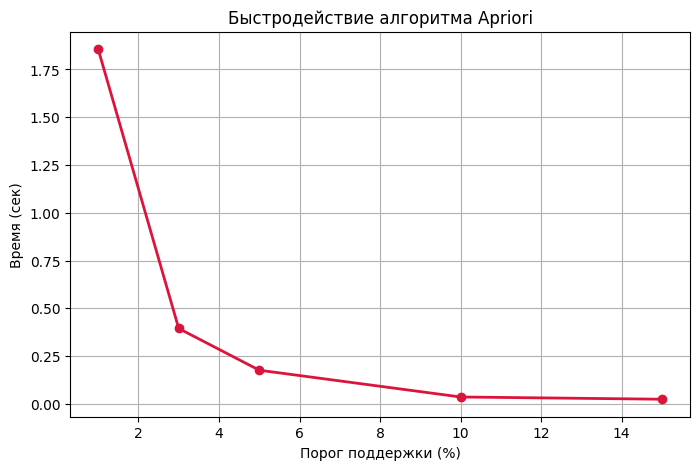

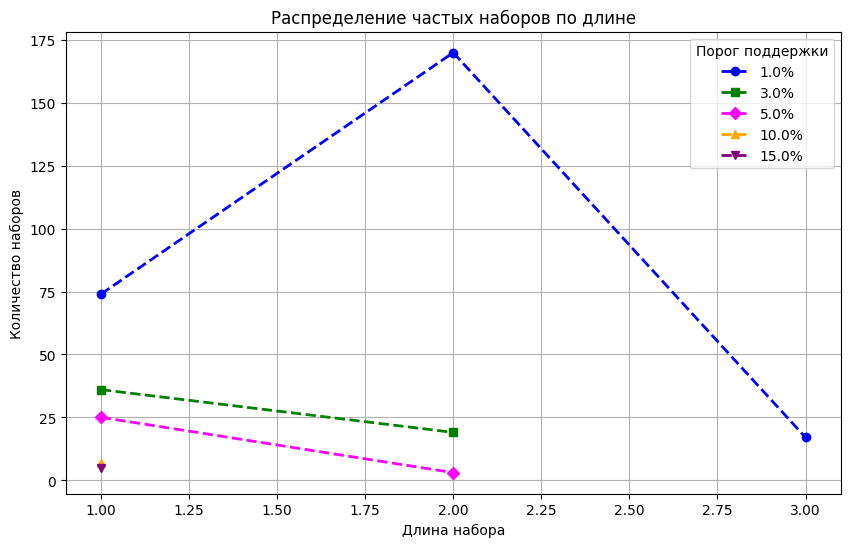

In [7]:
import csv
import time
import itertools
import collections
import matplotlib.pyplot as plt
import chardet

def detect_file_encoding(path):
    with open(path, 'rb') as f:
        sample = f.read(10000)
    encoding = chardet.detect(sample)['encoding']
    print("Кодировка:", encoding)
    return encoding

def load_transactions(path):
    encoding = detect_file_encoding(path)
    transactions = []
    with open(path, 'r', encoding=encoding) as f:
        reader = csv.reader(f)
        for row in reader:
            items = {x.strip() for x in row if x.strip()}
            if items:
                transactions.append(items)
    return transactions

def compute_support(itemset, transactions):
    return sum(1 for t in transactions if itemset.issubset(t)) / len(transactions)

def apriori_algorithm(transactions, min_support):
    freq_itemsets = {}
    total = len(transactions)
    counter = collections.Counter()
    for t in transactions:
        for item in t:
            counter[frozenset([item])] += 1
    level1 = {fs: cnt / total for fs, cnt in counter.items() if cnt / total >= min_support}
    freq_itemsets.update(level1)
    current = set(level1.keys())
    k = 2
    while current:
        candidates = set()
        for a, b in itertools.combinations(current, 2):
            cand = a | b
            if len(cand) == k and all(frozenset(sub) in current for sub in itertools.combinations(cand, k - 1)):
                candidates.add(cand)
        counts = collections.Counter()
        for t in transactions:
            for cand in candidates:
                if cand.issubset(t):
                    counts[cand] += 1
        next_level = {fs: cnt / total for fs, cnt in counts.items() if cnt / total >= min_support}
        if not next_level:
            break
        freq_itemsets.update(next_level)
        current = set(next_level.keys())
        k += 1
    return freq_itemsets

def order_results(freq_itemsets, mode='support'):
    if mode == 'support':
        return sorted(freq_itemsets.items(), key=lambda x: (-x[1], sorted(x[0])))
    elif mode == 'lex':
        return sorted(freq_itemsets.items(), key=lambda x: (sorted(x[0]), -x[1]))
    return list(freq_itemsets.items())

def execute_experiments(transactions, thresholds, order_mode='support'):
    runtime_results = []
    length_stats = {}
    for thresh in thresholds:
        start = time.time()
        freq_sets = apriori_algorithm(transactions, thresh)
        elapsed = time.time() - start
        runtime_results.append(elapsed)
        lengths = collections.Counter(len(item) for item in freq_sets.keys())
        length_stats[thresh] = dict(lengths)
        ordered = order_results(freq_sets, mode=order_mode)
        print(f"Порог: {thresh*100:.1f}%; время: {elapsed:.4f} сек; наборов: {len(ordered)}")
    return runtime_results, length_stats

if __name__ == "__main__":
    data_path = "/content/baskets.csv"
    transactions_data = load_transactions(data_path)

    support_levels = [0.01, 0.03, 0.05, 0.10, 0.15]
    runtimes, length_distribution = execute_experiments(transactions_data, support_levels, order_mode='support')

    plt.figure(figsize=(8, 5))
    plt.plot([s*100 for s in support_levels], runtimes, marker='o', color='crimson', linestyle='-', linewidth=2)
    plt.xlabel("Порог поддержки (%)")
    plt.ylabel("Время (сек)")
    plt.title("Быстродействие алгоритма Apriori")
    plt.grid(True)
    plt.savefig("time_vs_support.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    markers = ['o', 's', 'D', '^', 'v']
    colors = ['blue', 'green', 'magenta', 'orange', 'purple']
    for i, s in enumerate(support_levels):
        xs = sorted(length_distribution[s].keys())
        ys = [length_distribution[s].get(x, 0) for x in xs]
        plt.plot(xs, ys, marker=markers[i % len(markers)], color=colors[i % len(colors)],
                 label=f'{s*100:.1f}%', linestyle='--', linewidth=2)
    plt.xlabel("Длина набора")
    plt.ylabel("Количество наборов")
    plt.title("Распределение частых наборов по длине")
    plt.legend(title="Порог поддержки")
    plt.grid(True)
    plt.savefig("itemset_distribution.png")
    plt.show()
